# Copyright Netherlands eScience Center <br>
** Function     : Evaluate S2S BCC sic forecast with sea ice from ERA-Interim** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2020.08.21 ** <br>
** Last Update  : 2020.08.21 ** <br>
Description     : This notebook aims to evaluate the S2S BCC sea ice data against the ERA-Interim sea ice. The native resolution of S2S BCC data is 1.5 deg and ERA-Interim is 0.75 deg. Therefore we select latitudes without interpolation. From high resolution (ERA-Interim) to low resolution (S2S BCC) grid.<br>
Return Values   : netCDF4 <br>
Caveat          :

The selection of latitudes follows the nearest neighbour rule.<br>

In [1]:
import numpy as np
import scipy
from netCDF4 import Dataset
import sys
#sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
sys.path.append("../../DLACs")
import dlacs
import dlacs.preprocess
import os
import dlacs.visual
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [5]:
################################   Input zone  ######################################
# specify data path
# SICpm fields
datapath_BCC = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/S2S/BCCens'
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ERA-Interim'
# sample
BCC_control_key = Dataset(os.path.join(datapath_BCC,"sic_weekly_S2S_BCC_control_2015_2016.nc"))
#BCC_ensemble_key = Dataset(os.path.join(datapath_BCC,"sic_weekly_S2S_BCC_ensemble_2015_2016.nc"))
ERAI_key = Dataset(os.path.join(datapath_ERAI,"sic_weekly_erai_1979_2017.nc"))
# specify output path for figures
output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/Maps/Barents'
####################################################################################

In [6]:
#########################   Basic dimensions of data #########################
# Barents Sea  @ W:18 E:60 N:80 S:64
latitude_BCC = BCC_control_key.variables['latitude'][7:19]
longitude_BCC = BCC_control_key.variables['longitude'][132:160] - 180
year_BCC = BCC_control_key.variables['year'][:-1]

latitude_ERAI = ERAI_key.variables['latitude'][13:36:2]
longitude_ERAI = ERAI_key.variables['longitude'][264:320:2]
year_ERAI = ERAI_key.variables['year'][36:-1]
print("==============================    BCC    =============================")
print("Latitude")
print(latitude_BCC.shape)
print(latitude_BCC)
print("Longitude")
print(longitude_BCC.shape)
print(longitude_BCC)
print("Year")
print(year_BCC)
print("============================    ERA-Interim    ===========================")
print("Latitude")
print(latitude_ERAI.shape)
print(latitude_ERAI)
print("Longitude")
print(longitude_ERAI.shape)
print(longitude_ERAI)
print("Year")
print(year_ERAI)
####################################################################################

==============================    BCC    =============================
Latitude
(12,)
[79.5 78.  76.5 75.  73.5 72.  70.5 69.  67.5 66.  64.5 63. ]
Longitude
(28,)
[18.  19.5 21.  22.5 24.  25.5 27.  28.5 30.  31.5 33.  34.5 36.  37.5
 39.  40.5 42.  43.5 45.  46.5 48.  49.5 51.  52.5 54.  55.5 57.  58.5]
Year
[2015]
============================    ERA-Interim    ===========================
Latitude
(12,)
[79.75 78.25 76.75 75.25 73.75 72.25 70.75 69.25 67.75 66.25 64.75 63.25]
Longitude
(28,)
[18.  19.5 21.  22.5 24.  25.5 27.  28.5 30.  31.5 33.  34.5 36.  37.5
 39.  40.5 42.  43.5 45.  46.5 48.  49.5 51.  52.5 54.  55.5 57.  58.5]
Year
[2015 2016]


In [7]:
print ('*******************  evaluation matrix  *********************')
# The prediction will be evaluated through RMSE against climatology
    
# error score for temporal-spatial fields, without keeping spatial pattern
def RMSE(x,y):
    """
    Calculate the RMSE. x is input series and y is reference series.
    It calculates RMSE over the domain, not over time. The spatial structure
    will not be kept.
    Parameter
    ----------------------
    x: input time series with the shape [time, lat, lon]
    """
    x_series = x.reshape(x.shape[0],-1)
    y_series = y.reshape(y.shape[0],-1)
    rmse = np.sqrt(np.mean((x_series - y_series)**2,1))
    rmse_std = np.sqrt(np.std((x_series - y_series)**2,1))
    
    return rmse, rmse_std
    
# error score for temporal-spatial fields, keeping spatial pattern
def MAE(x,y):
    """
    Calculate the MAE. x is input series and y is reference series.
    It calculate MAE over time and keeps the spatial structure.
    """
    mae = np.mean(np.abs(x-y),0)
        
    return mae

*******************  evaluation matrix  *********************


In [8]:
# size of the grid box
# longitude for BCC grid 1.5 deg 240 points
dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_BCC /
                                        360) / 240 / 2 # weight by 2 to make it equivalent to our study with ERA-Interim grid
# latitude for BCC grid 1.5 deg 120 points
dy = np.pi * constant['R'] / 240 / 2 # weight by 2 to make it equivalent to our study with ERA-Interim grid

In [11]:
#########################   load and preprocess data   #########################
sic_BCC = BCC_control_key.variables['sic'][:,:,:,7:19,132:160]          #[year, week, leadweek, lat, lon]
#sic_BCC_ens = BCC_ensemble_key.variables['sic'][:,:-1,:,:,7:19,132:160]  #[ens, year, week, leadweek, lat, lon]
print(sic_BCC.shape)

sic_ERAI = ERAI_key.variables['sic'][36:-1, :, 13:36:2, 264:320:2]   #[year, week, lat, lon]
print(sic_ERAI.shape)

# weight sea ice by area
sic_BCC_area = np.zeros(sic_BCC.shape, dtype=float)
sic_ERAI_area = np.zeros(sic_ERAI.shape, dtype=float)

for i in np.arange(len(latitude_BCC[:])):
    # change the unit to km2
    sic_BCC_area[:,:,:,i,:] = sic_BCC[:,:,:,i,:]* dx[i] * dy / 1E+6 # unit km2
    sic_ERAI_area[:,:,i,:] = sic_ERAI[:,:,i,:]* dx[i] * dy / 1E+6 # unit km2

# land sea mask correction for NCEP data using ERAI
leadTime = 6
sic_ERAI_area_expand = np.repeat(sic_ERAI_area[:,:,np.newaxis,:,:],leadTime,2)

sic_BCC_area[sic_ERAI_area_expand<0] = 0
sic_BCC_area[sic_ERAI_area_expand==0] = 0
sic_BCC_area[sic_BCC_area<0] = 0

sic_ERAI_area[sic_ERAI_area<0] = 0 # switch the mask from -1 to 0
# reshape the signal to series
sic_ERAI_area_series = dlacs.preprocess.operator.unfold(sic_ERAI_area)

y, w, lw, lat, lon = sic_BCC_area.shape
sic_BCC_area_series = sic_BCC_area.reshape(y*w, lw, lat, lon)

(2, 48, 6, 12, 28)
(2, 48, 12, 28)


In [12]:
#########################   metrics and evaluate forecast #########################
print(sic_BCC_area_series.shape)
#print(sic_BCC_area_series[0,0,:,:])
print("================================================")
print(sic_ERAI_area_series.shape)
#print(sic_ERAI_area_series[0,:,:])
#################################################################################
########                performance evaluation with RMSE                 ########
########              RMSE over time, and sum over domain                ########
########               from 2015 - 2016, 2 years in total                ########
#################################################################################
print('##############################################################')
print('############   start prediction with persistence  ############')
print('##############################################################')
RMSE_persist_0, RMSE_persist_0_std = RMSE(sic_ERAI_area_series[:-1,:,:],
                                          sic_ERAI_area_series[1:,:,:])
RMSE_persist_1, RMSE_persist_1_std = RMSE(sic_ERAI_area_series[:-2,:,:],
                                          sic_ERAI_area_series[2:,:,:])
RMSE_persist_2, RMSE_persist_2_std = RMSE(sic_ERAI_area_series[:-3,:,:],
                                          sic_ERAI_area_series[3:,:,:])
RMSE_persist_3, RMSE_persist_3_std = RMSE(sic_ERAI_area_series[:-4,:,:],
                                          sic_ERAI_area_series[4:,:,:])
RMSE_persist_4, RMSE_persist_4_std = RMSE(sic_ERAI_area_series[:-5,:,:],
                                          sic_ERAI_area_series[5:,:,:])
RMSE_persist_5, RMSE_persist_5_std = RMSE(sic_ERAI_area_series[:-6,:,:],
                                          sic_ERAI_area_series[6:,:,:])
print('#################################################################################')
print('############   evaluation and statistical matrix for the entire year ############')
print('#################################################################################')
RMSE_BCC_0, RMSE_BCC_0_std = RMSE(sic_BCC_area_series[:,0,:,:],
                                    sic_ERAI_area_series)
RMSE_BCC_1, RMSE_BCC_1_std = RMSE(sic_BCC_area_series[:-1,1,:,:],
                                    sic_ERAI_area_series[1:,:,:])
RMSE_BCC_2, RMSE_BCC_2_std = RMSE(sic_BCC_area_series[:-2,2,:,:],
                                    sic_ERAI_area_series[2:,:,:])
RMSE_BCC_3, RMSE_BCC_3_std = RMSE(sic_BCC_area_series[:-3,3,:,:],
                                    sic_ERAI_area_series[3:,:,:])
RMSE_BCC_4, RMSE_BCC_4_std = RMSE(sic_BCC_area_series[:-4,4,:,:],
                                    sic_ERAI_area_series[4:,:,:])
RMSE_BCC_5, RMSE_BCC_5_std = RMSE(sic_BCC_area_series[:-5,5,:,:],
                                    sic_ERAI_area_series[5:,:,:])
print("*******************     Lead time 0     *******************")
print("Mean RMSE with testing data - BCC")
print(np.mean(RMSE_BCC_0),"+-",np.mean(RMSE_BCC_0_std))
print("Mean RMSE with testing data - Persistence")
print(np.mean(RMSE_persist_0),"+-",np.mean(RMSE_persist_0_std))
print("*******************     Lead time 1     *******************")
print("Mean RMSE with testing data - BCC")
print(np.mean(RMSE_BCC_1),"+-",np.mean(RMSE_BCC_1_std))
print("Mean RMSE with testing data - Persistence")
print(np.mean(RMSE_persist_1),"+-",np.mean(RMSE_persist_1_std))
print("*******************     Lead time 2     *******************")
print("Mean RMSE with testing data - BCC")
print(np.mean(RMSE_BCC_2),"+-",np.mean(RMSE_BCC_2_std))
print("Mean RMSE with testing data - Persistence")
print(np.mean(RMSE_persist_2),"+-",np.mean(RMSE_persist_2_std))
print("*******************     Lead time 3     *******************")
print("Mean RMSE with testing data - BCC")
print(np.mean(RMSE_BCC_3),"+-",np.mean(RMSE_BCC_3_std))
print("Mean RMSE with testing data - Persistence")
print(np.mean(RMSE_persist_3),"+-",np.mean(RMSE_persist_3_std))
print("*******************     Lead time 4     *******************")
print("Mean RMSE with testing data - BCC")
print(np.mean(RMSE_BCC_4),"+-",np.mean(RMSE_BCC_4_std))
print("Mean RMSE with testing data - Persistence")
print(np.mean(RMSE_persist_4),"+-",np.mean(RMSE_persist_4_std))
print("*******************     Lead time 5     *******************")
print("Mean RMSE with testing data - BCC")
print(np.mean(RMSE_BCC_5),"+-",np.mean(RMSE_BCC_5_std))
print("Mean RMSE with testing data - Persistence")
print(np.mean(RMSE_persist_5),"+-",np.mean(RMSE_persist_5_std))
print('##############################################################')
print('############           create a txt file          ############')
print('##############################################################')
f = open(os.path.join(output_path,"report_rmse_S2S_BCC_ERAI_pred.txt"),"w+")
f.write("############   evaluation of prediction   ############\n")
f.write("############   Total RMSE with testing data   ############\n")
f.write("*******************     Lead time 0     *******************\n")
f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_BCC_0),np.mean(RMSE_BCC_0_std)))
f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_0),np.mean(RMSE_persist_0_std)))
f.write("*******************     Lead time 1     *******************\n")
f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_BCC_1),np.mean(RMSE_BCC_1_std)))
f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_1),np.mean(RMSE_persist_1_std)))
f.write("*******************     Lead time 2     *******************\n")
f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_BCC_2),np.mean(RMSE_BCC_2_std)))
f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_2),np.mean(RMSE_persist_2_std)))
f.write("*******************     Lead time 3     *******************\n")
f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_BCC_3),np.mean(RMSE_BCC_3_std)))
f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_3),np.mean(RMSE_persist_3_std)))
f.write("*******************     Lead time 4     *******************\n")
f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_BCC_4),np.mean(RMSE_BCC_4_std)))
f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_4),np.mean(RMSE_persist_4_std)))
f.write("*******************     Lead time 5     *******************\n")
f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_BCC_5),np.mean(RMSE_BCC_5_std)))
f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_5),np.mean(RMSE_persist_5_std)))
f.close()

(96, 6, 12, 28)
(96, 12, 28)
##############################################################
############   start prediction with persistence  ############
##############################################################
#################################################################################
############   evaluation and statistical matrix for the entire year ############
#################################################################################
*******************     Lead time 0     *******************
Mean RMSE with testing data - BCC
149.52949699724368 +- 263.2560652951754
Mean RMSE with testing data - Persistence
43.12017788736106 +- 89.64163944782553
*******************     Lead time 1     *******************
Mean RMSE with testing data - BCC
149.61723312029048 +- 261.6625641436904
Mean RMSE with testing data - Persistence
62.76706824827349 +- 128.73389507195972
*******************     Lead time 2     *******************
Mean RMSE with testing data - BCC
149.9590795

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


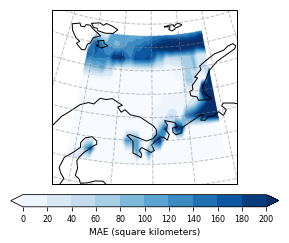

In [13]:
#########################   visualization of difference #########################
mae = MAE(sic_BCC_area_series[:,0,:,:],sic_ERAI_area_series)
label = 'MAE (square kilometers)'
ticks = [i for i in np.linspace(0,200,11)]
dlacs.visual.plots.geograph(latitude_BCC, longitude_BCC,
                            mae, label, ticks,
                            os.path.join(output_path,'spatial_sic_mae_avg_s2s_BCC_ERAI_2015_2016.png'),
                            boundary='Barents_Polar', colormap='Blues')

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


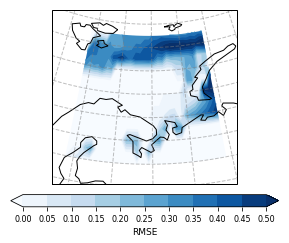

In [14]:
#########################   visualization of difference #########################
sic_ERAI_series = dlacs.preprocess.operator.unfold(sic_ERAI)
sic_BCC_series = sic_BCC.reshape(y*w, lw, lat, lon)

leadTime = 6
sic_ERAI_series_expand = np.repeat(sic_ERAI_series[:,np.newaxis,:,:],leadTime,1)

sic_BCC_series[sic_ERAI_series_expand<0] = 0
sic_BCC_series[sic_ERAI_series_expand==0] = 0
sic_BCC_series[sic_BCC_series<0] = 0

sic_ERAI_series[sic_ERAI_series<0] = 0 # switch the mask from -1 to 0

rmse = np.sqrt(np.mean((sic_ERAI_series - sic_BCC_series[:,0,:,:])**2,0))
label = 'RMSE'
ticks = [i for i in np.linspace(0,0.5,11)]
dlacs.visual.plots.geograph(latitude_BCC, longitude_BCC,
                            rmse, label, ticks,
                            os.path.join(output_path,'spatial_sic_rmse_avg_s2s_BCC_ERAI_2015_2016.png'),
                            boundary='Barents_Polar', colormap='Blues')